In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pyeem

In [2]:
pyeem.instruments.supported

name
manufacturer supported_models              
Agilent      Cary 4E                cary_4e
             Cary Eclipse      cary_eclipse
Horiba       Aqualog-880-C          aqualog
             SPEX Fluorolog-3     fluorolog
Tecan        Spark                    spark

In [3]:
data_dir = "../../../../local_test_data/early_test_tecan"
calibration_sources = {
    "Microcystis": "cells/ml",
    "Chlorella": "cells/ml"
}
dataset = pyeem.datasets.Dataset(
    data_dir=data_dir,
    calibration_sources=calibration_sources,
    raman_instrument=None,
    absorbance_instrument=None,
    eem_instrument="spark"
)

In [4]:
display(dataset.meta_df)

datetime_utc          filename description  \
sample_set scan_type                                                      
1          blank_eem  2020-07-29 10:30:00   blank_eem1.xlsx          C1   
           sample_eem 2020-07-29 10:45:00  sample_eem1.xlsx          C2   
           sample_eem 2020-08-04 11:00:00  sample_eem2.xlsx          C3   
           sample_eem 2020-08-04 12:00:00  sample_eem3.xlsx          C4   
           sample_eem 2020-08-04 13:00:00  sample_eem4.xlsx          C5   
           sample_eem 2020-08-05 13:00:00  sample_eem5.xlsx          D1   
           sample_eem 2020-08-06 13:00:00  sample_eem6.xlsx          D2   
           sample_eem 2020-08-07 13:00:00  sample_eem7.xlsx          D3   
           sample_eem 2020-08-08 13:00:00  sample_eem8.xlsx          D4   

                      comments collected_by  dilution  Microcystis  Chlorella  \
sample_set scan_type                                                            
1          blank_eem                              1.0          0.0        0.0   
           sample_eem                             1.0    4470000.0        0.0   
           sample_eem                             1.0    2235000.0        0.0   
           sample_eem                             1.0     447000.0        0.0   
           sample_eem                             1.0      89400.0        0.0   
           sample_eem                             1.0          0.0  5000000.0   
           sample_eem                             1.0          0.0  2500000.0   
           sample_eem                             1.0          0.0   500000.0   
           sample_eem                             1.0          0.0   100000.0   

                       calibration_sample  prototypical_sample  test_sample  \
sample_set scan_type                                                          
1          blank_eem                False                False        False   
           sample_eem                True                 True        False   
           sample_eem                True                False        False   
           sample_eem                True                False        False   
           sample_eem                True                False        False   
           sample_eem                True                 True        False   
           sample_eem                True                False        False   
           sample_eem                True                False        False   
           sample_eem                True                False        False   

                                                                filepath  \
sample_set scan_type                                                       
1          blank_eem   /home/roboat/Documents/roboat/PyEEM/local_test...   
           sample_eem  /home/roboat/Documents/roboat/PyEEM/local_test...   
           sample_eem  /home/roboat/Documents/roboat/PyEEM/local_test...   
           sample_eem  /home/roboat/Documents/roboat/PyEEM/local_test...   
           sample_eem  /home/roboat/Documents/roboat/PyEEM/local_test...   
           sample_eem  /home/roboat/Documents/roboat/PyEEM/local_test...   
           sample_eem  /home/roboat/Documents/roboat/PyEEM/local_test...   
           sample_eem  /home/roboat/Documents/roboat/PyEEM/local_test...   
           sample_eem  /home/roboat/Documents/roboat/PyEEM/local_test...   

                              name                       hdf_path  
sample_set scan_type                                               
1          blank_eem    blank_eem1   raw_sample_sets/1/blank_eem1  
           sample_eem  sample_eem1  raw_sample_sets/1/sample_eem1  
           sample_eem  sample_eem2  raw_sample_sets/1/sample_eem2  
           sample_eem  sample_eem3  raw_sample_sets/1/sample_eem3  
           sample_eem  sample_eem4  raw_sample_sets/1/sample_eem4  
           sample_eem  sample_eem5  raw_sample_sets/1/sample_eem5  
           sample_eem  sample_eem6  raw_sample_sets/1/sample

In [5]:
routine_df = pyeem.preprocessing.create_routine(
    crop=False,
    fill_missing_values=True,
    blank_subtraction=True,
    scatter_removal=True,
)
display(routine_df)

,step_name,hdf_path
step_order,,
0,raw,raw_sample_sets/
1,fill_missing_values,preprocessing/filters/fill_missing_values
2,blank_subtraction,preprocessing/corrections/blank_subtraction
3,scatter_removal,preprocessing/corrections/scatter_removal
4,complete,preprocessing/complete/


In [9]:
# Just an example crop dim
#crop_dims = {"emission_bounds": (600, 750), "excitation_bounds": (-np.inf, np.inf)}

# Keep everything
crop_dims = {"emission_bounds": (-np.inf, np.inf), "excitation_bounds": (-np.inf, np.inf)}

# microcystis peak
#crop_dims = {"emission_bounds": (640, 650),"excitation_bounds": (610, 630)}

# chlorella peak
#crop_dims = {"emission_bounds": (670, 710),"excitation_bounds": (-np.inf, 480)}

kwargs = {
    "crop_dims": crop_dims,
    "band": "rayleigh",
    "order": "first",
    "excision_width": 45,
    "fill": "interp"
}

routine_results_df = pyeem.preprocessing.perform_routine(
    dataset, routine_df, progress_bar=True, **kwargs
)
#display(routine_results_df)

Preprocessing scan sets: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


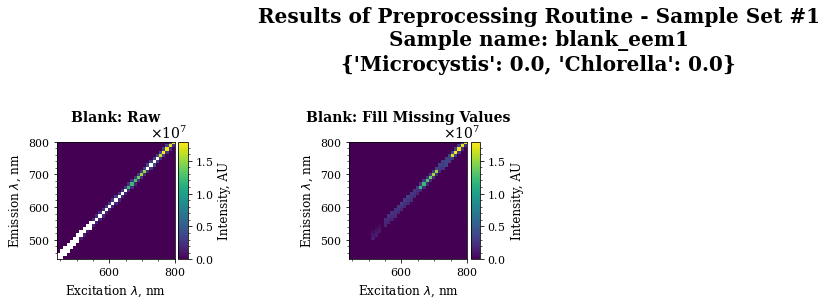

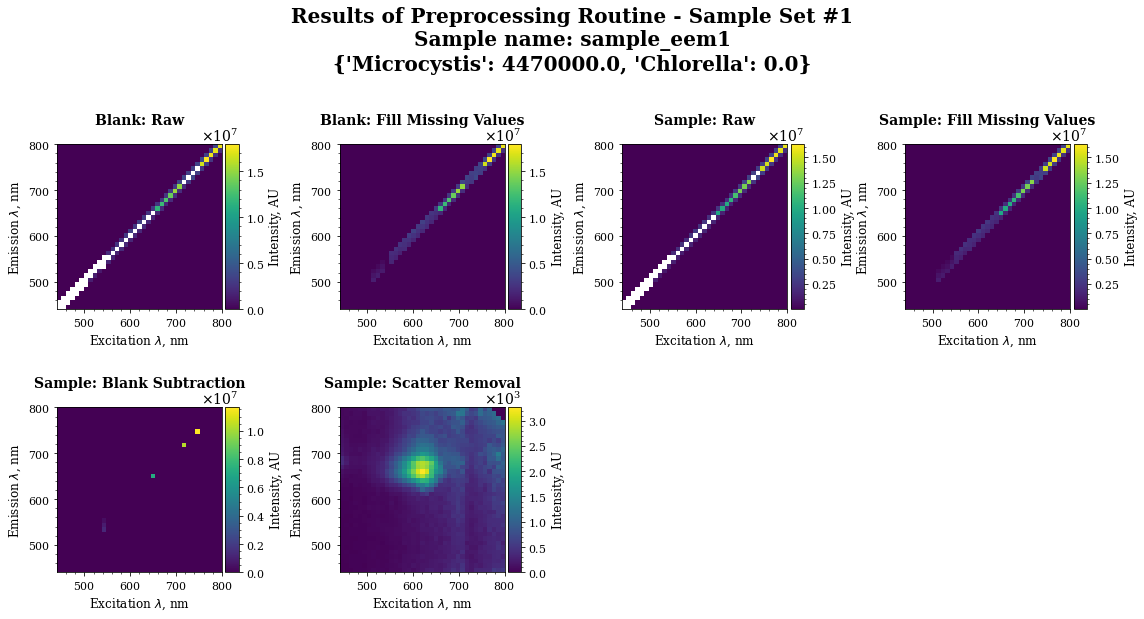

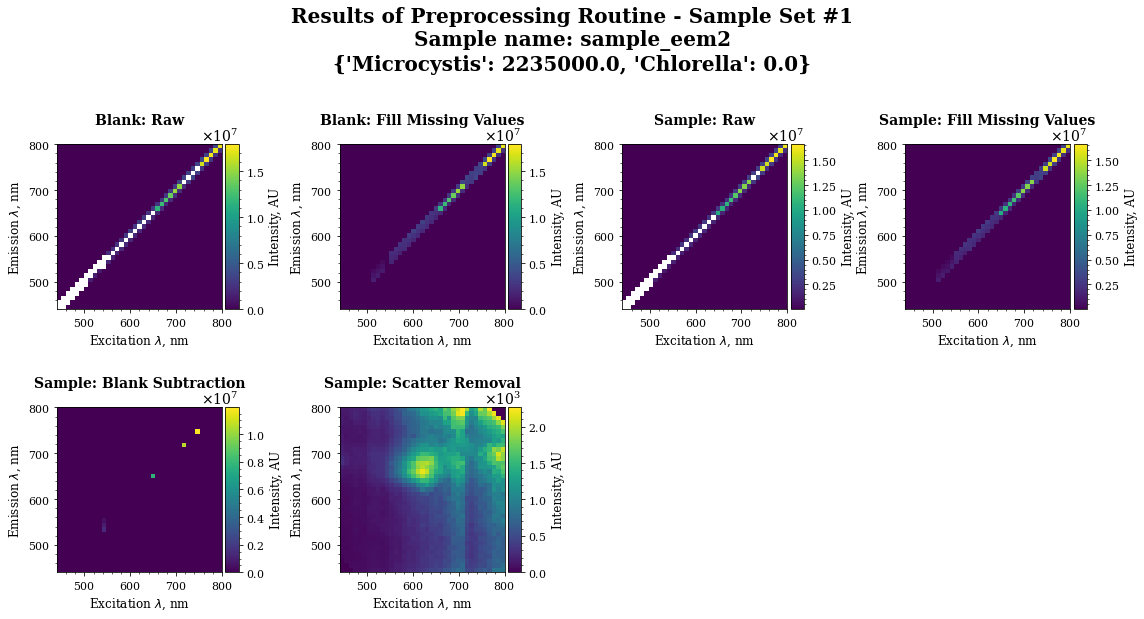

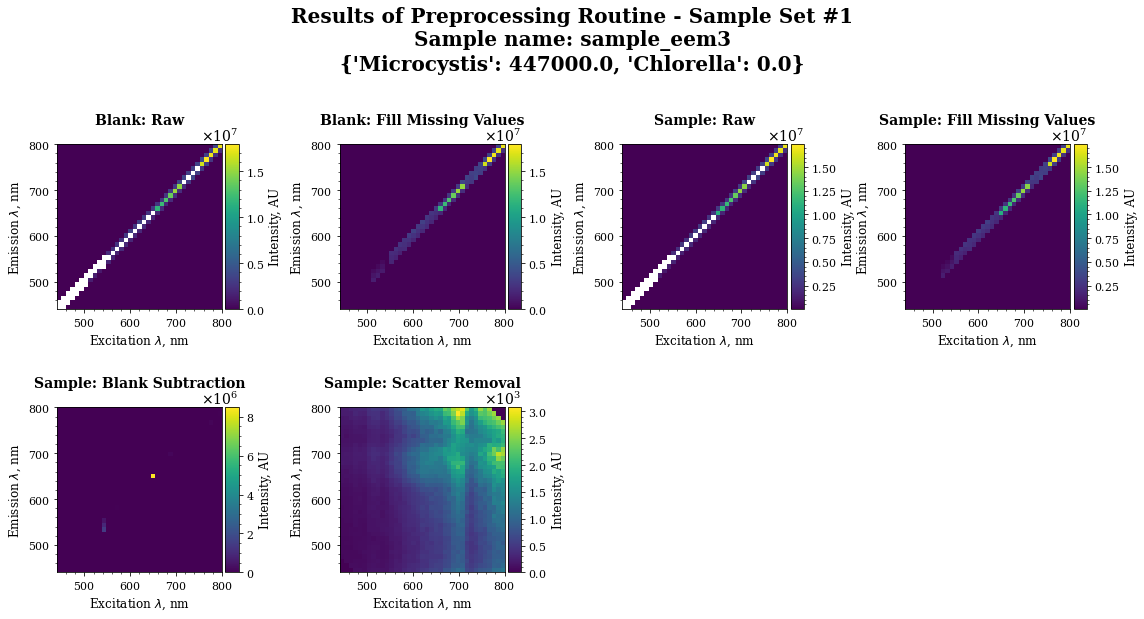

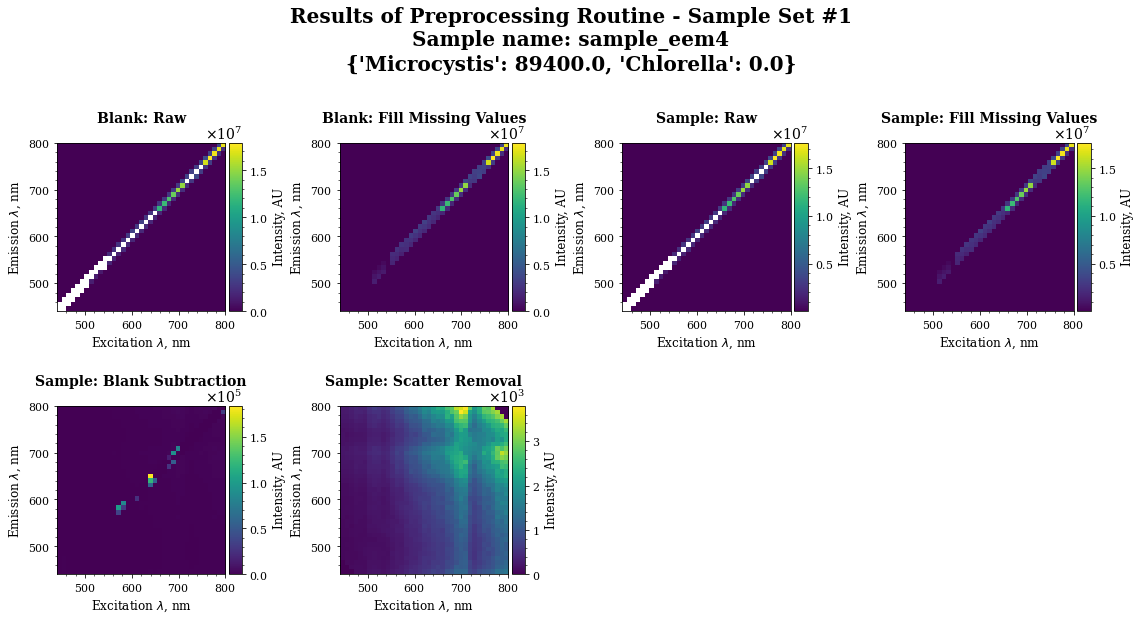

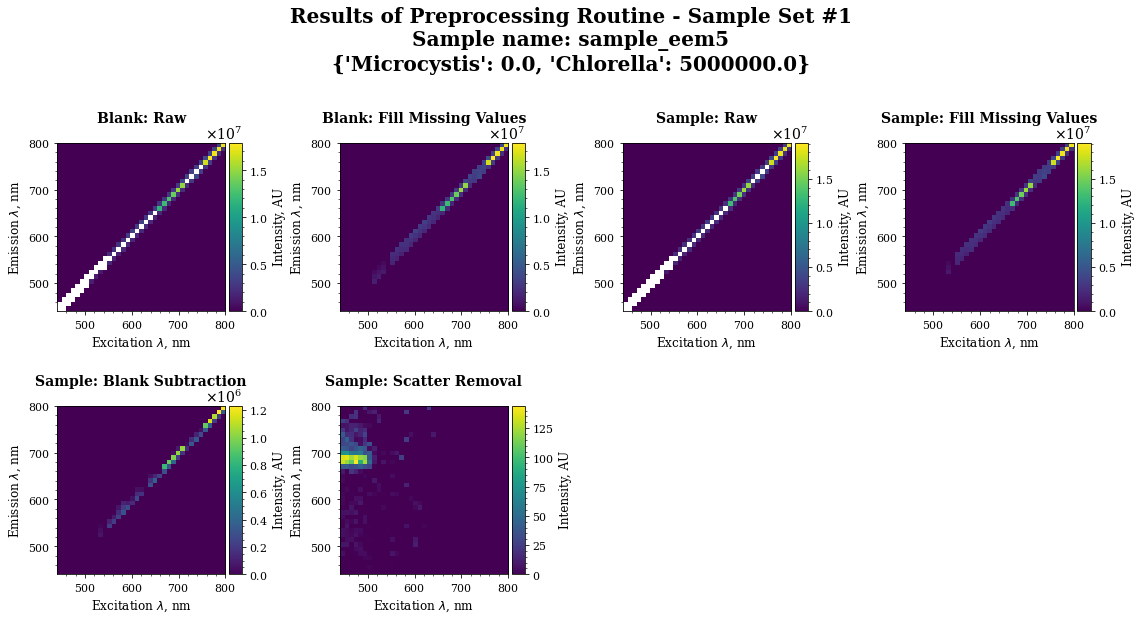

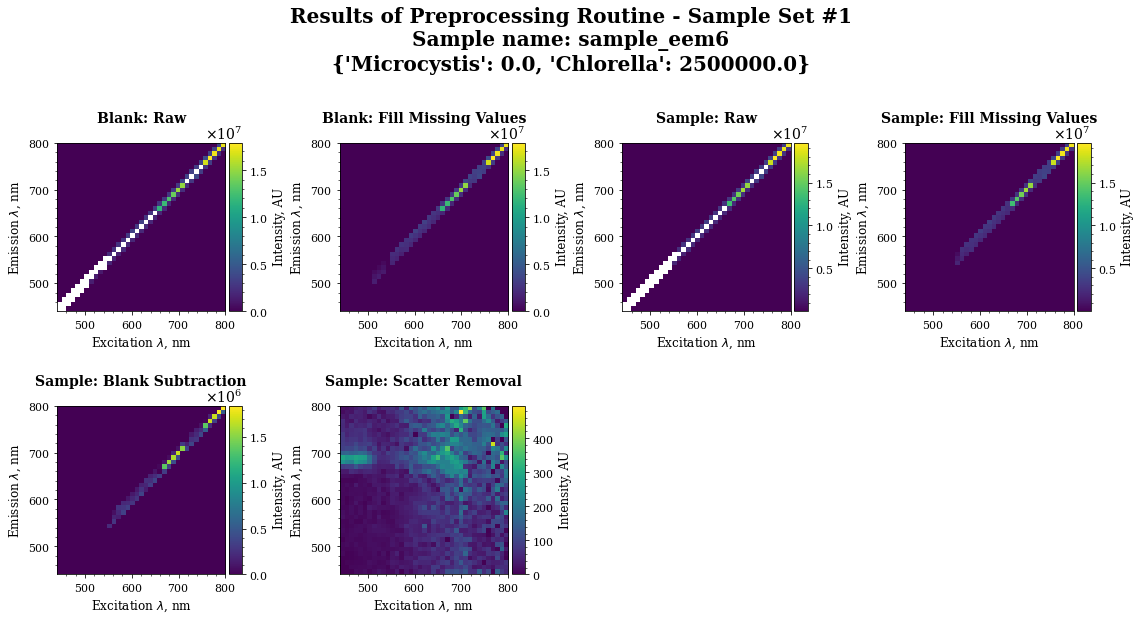

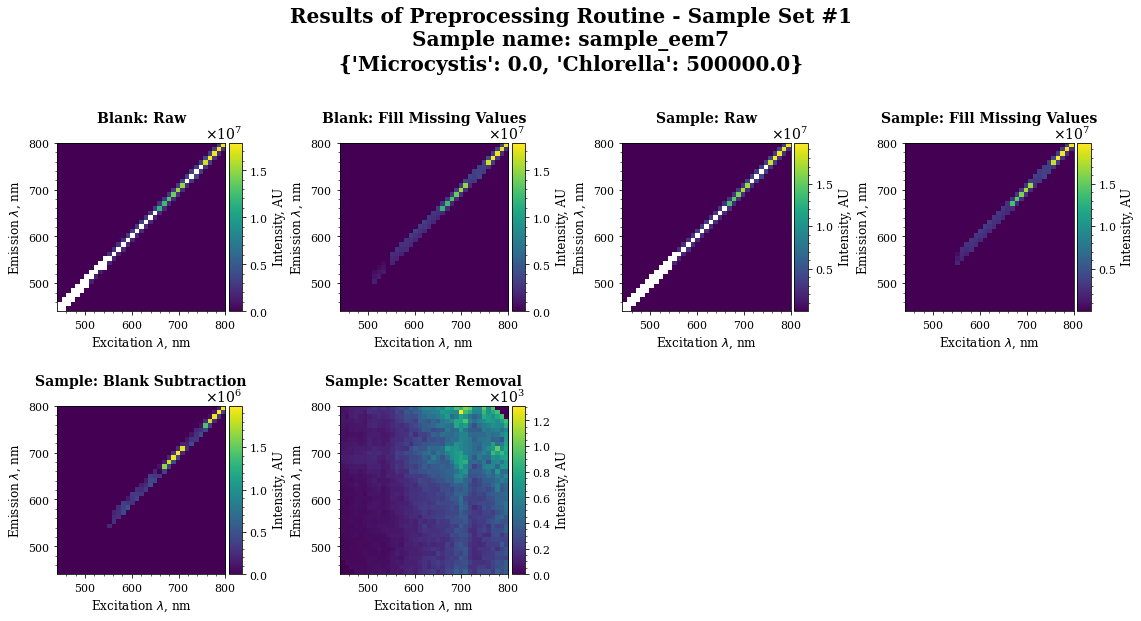

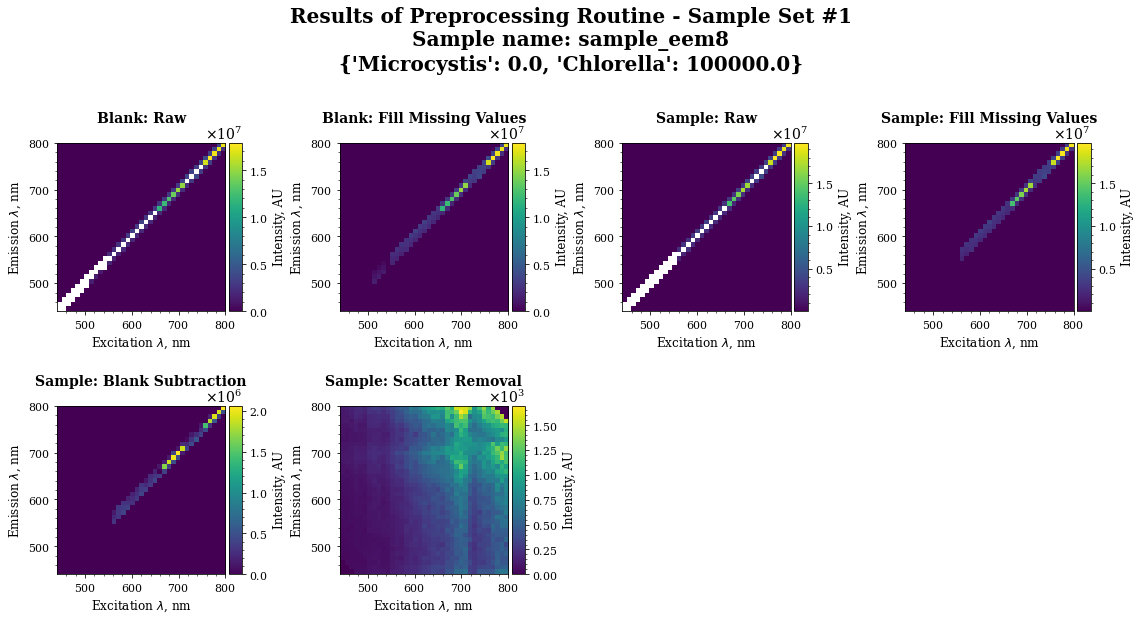

In [10]:
for group_name, group in dataset.meta_df.groupby(["sample_set", "name"]):
    sample_set = group_name[0]
    sample_name = group_name[1]
    
    # Custom suptitle for the plot to be passed as kwarg
    title = dict(zip(
        dataset.calibration_sources.keys(),
        group[dataset.calibration_sources.keys()].values[0]
    ))
    suptitle = "Results of Preprocessing Routine - Sample Set #{0}\nSample name: {1}".format(
        sample_set, sample_name
    )
    suptitle += "\n" + str(title)
    
    pyeem.plots.preprocessing.plot_preprocessing(
        dataset, 
        routine_results_df,
        sample_set,
        sample_name,
        plot_type="imshow",
        suptitle = suptitle
    )
    plt.show()

In [11]:
cal_df = pyeem.preprocessing.calibration(
    dataset, routine_results_df
)

In [12]:
display(cal_df)

concentration  \
source      source_units intensity_units measurement_units        slope     intercept    r_squared                  
Microcystis cells/ml     Intensity, AU   Integrated Intensity, AU -0.133031 1.159480e+06 0.936216       4470000.0   
                                                                                         0.936216       2235000.0   
                                                                                         0.936216        447000.0   
                                                                                         0.936216         89400.0   
Chlorella   cells/ml     Intensity, AU   Integrated Intensity, AU -0.101429 4.592137e+05 0.853449       5000000.0   
                                                                                         0.853449       2500000.0   
                                                                                         0.853449        500000.0   
                                                                                         0.853449        100000.0   

                                                                                                    integrated_intensity  \
source      source_units intensity_units measurement_units        slope     intercept    r_squared                         
Microcystis cells/ml     Intensity, AU   Integrated Intensity, AU -0.133031 1.159480e+06 0.936216           5.835575e+05   
                                                                                         0.936216           8.371213e+05   
                                                                                         0.936216           1.020826e+06   
                                                                                         0.936216           1.233085e+06   
Chlorella   cells/ml     Intensity, AU   Integrated Intensity, AU -0.101429 4.592137e+05 0.853449           3.880000e+03   
                                                                                         0.853449           1.101272e+05   
                                                                                         0.853449           3.469055e+05   
                                                                                         0.853449           5.543683e+05   

                                                                                                    prototypical_sample  \
source      source_units intensity_units measurement_units        slope     intercept    r_squared                        
Microcystis cells/ml     Intensity, AU   Integrated Intensity, AU -0.133031 1.159480e+06 0.936216                  True   
                                                                                         0.936216                 False   
                                                                                         0.936216                 False   
                                                                                         0.936216                 False   
Chlorella   cells/ml     Intensity, AU   Integrated Intensity, AU -0.101429 4.592137e+05 0.853449                  True   
                                                                                         0.853449                 False   
                                                                                         0.853449                 False   
                                                                                         0.853449                 False   

                                                                                                                                hdf_path  
source      source_units intensity_units measurement_units        slope     intercept    r_squared                                        
Microcystis cells/ml     Intensity, AU   Integrated Intensity, AU -0.133031 1.159480e+06 0.936216   preprocessing/complete/1/sample_eem1  
                                        

In [13]:
cal_summary_df = pyeem.preprocessing.calibration_summary_info(
    cal_df
)
display(cal_summary_df)

,source,source_units,intensity_units,measurement_units,slope,intercept,r_squared,Number of Samples,Min. Concentration,Max. Concentration
0,Microcystis,cells/ml,"Intensity, AU","Integrated Intensity, AU",-0.133031,1.159480e+06,0.936216,4.0,89400.0,4470000.0
1,Chlorella,cells/ml,"Intensity, AU","Integrated Intensity, AU",-0.101429,4.592137e+05,0.853449,4.0,100000.0,5000000.0


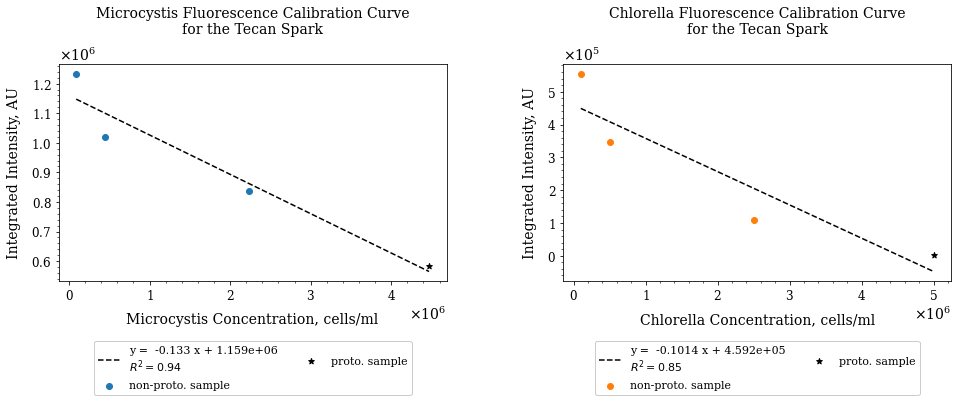

In [14]:
axes = pyeem.plots.calibration_curves_plot(
    dataset, cal_df
)
plt.show()

In [ ]:
display(dataset.meta_df)

In [ ]:
proto_results_df = pyeem.augmentation.create_prototypical_spectra(
    dataset,
    cal_df
)
display(proto_results_df)

In [ ]:
axes = pyeem.plots.prototypical_spectra_plot(
    dataset,
    proto_results_df,
    plot_type="contour"
)
plt.show()

In [ ]:
ss_results_df = pyeem.augmentation.create_single_source_spectra(
    dataset,
    cal_df,
    conc_range=(0, 5000000),
    num_spectra=10
)
display(ss_results_df)

In [ ]:
from IPython.display import HTML
%matplotlib inline

source = "Chlorella"
anim = pyeem.plots.single_source_animation(
    dataset,
    ss_results_df,
    source=source,
    plot_type="imshow",
    fig_kws={"dpi": 120},
    animate_kws={"interval": 100, "blit": True},
)
HTML(anim.to_html5_video())

In [ ]:
data_dir = "../../../../local_test_data/early_test_tecan/tecan_raw"

In [ ]:
metadata_fp = os.path.join(data_dir, "metadata.csv")
meta_df = pd.read_csv(metadata_fp)

In [ ]:
import numpy as np

for name, group in meta_df.groupby("filename"):
    fp = os.path.join(data_dir, name)
    # Read in raw Tecan Spark data with index column equal to zero
    # and skipping the last row of data which contains End Time
    df = pd.read_excel(fp, index_col=0, skipfooter=1)
    # Drop columns and rows with all NaN values, these sometimes
    # appear at the end for some reason
    df.dropna(how="all", axis=1, inplace=True)
    df.dropna(how="all", axis=0, inplace=True)
    group["next_well"] = group['well_id'].shift(-1)

    for index, row in group.iterrows():
        display(row)
        tmp_df = df.loc[row["well_id"]:]
        if not pd.isna(row["next_well"]):
            tmp_df = df.loc[row["well_id"] : row["next_well"]].iloc[:-1]

        new_header = tmp_df.iloc[0] #grab the first row for the header
        tmp_df = tmp_df[1:] #take the data less the header row
        tmp_df.columns = new_header #set the header row as the df header
        tmp_df.index.name = None
        tmp_df.columns.name = None
        display(tmp_df.head())
